In [1]:
import torch
from transformers import AutoTokenizer
from transformers.models.llama import LlamaForCausalLM
from transformers.models.llama.modeling_llama import LlamaMLP
from torch.utils.data import DataLoader
from datasets import load_dataset
from model import *

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-04-08 09:20:54.245217: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPT

In [3]:
dtype = torch.bfloat16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and base model
tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-Instruct")
tokenizer.pad_token = tokenizer.eos_token

base_model = LlamaForCausalLM.from_pretrained("unsloth/Llama-3.2-1B-Instruct", torch_dtype=dtype)
base_model.to(device)
base_model.eval()


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-0

In [4]:
speculator_head = PredictorHead(base_model.model.config)
speculator_head.load_state_dict(torch.load("new_nn_decoder_head.pth"))
speculator_head.to(device, dtype=dtype)
specModel = TwoHeadModel(base_model, speculator_head)
specModel.to(device, dtype=dtype)
specModel.eval()

/tmp/ipykernel_6979/2495085176.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  speculator_head.load_state_dict(torch.load("new_nn_decoder_head.pth"))


TwoHeadModel(
  (base_model): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
      (layers): ModuleList(
        (0-15): 16 x LlamaDecoderLayer(
          (self_attn): LlamaAttention(
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (k_proj): Linear(in_features=2048, out_features=512, bias=False)
            (v_proj): Linear(in_features=2048, out_features=512, bias=False)
            (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
            (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
            (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
          (post_attention_layernorm): LlamaRMSNorm((2048,), e

In [5]:
class PrefixTuningModel(nn.Module):
    def __init__(self, base_model, speculator_head, prefix_length):
        """
        Args:
            base_model: The pre-trained LlamaForCausalLM model.
            speculator_head: The additional head (predicting the second token).
            prefix_length: Number of trainable prefix tokens.
        """
        super(PrefixTuningModel, self).__init__()
        self.base_model = base_model
        self.prefix_length = prefix_length
        self.hidden_size = base_model.config.hidden_size
        self.prefix_embeddings = nn.Parameter(torch.randn(prefix_length, self.hidden_size, dtype=dtype))
        self.main_head = base_model.lm_head
        self.speculator_head = speculator_head

    def forward(self, input_ids, attention_mask=None):
        batch_size = input_ids.shape[0]
        input_embeds = self.base_model.model.embed_tokens(input_ids)  # shape: [batch, seq_len, hidden_size]
        prefix_embeds = self.prefix_embeddings.unsqueeze(0).expand(batch_size, -1, -1)
        concat_embeds = torch.cat([prefix_embeds, input_embeds], dim=1)
        if attention_mask is not None:
            prefix_mask = torch.ones(batch_size, self.prefix_length, device=attention_mask.device)
            attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)
        outputs = self.base_model.model(inputs_embeds=concat_embeds, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # shape: [batch, (prefix+seq_len), hidden_size]
        logits_main = self.main_head(hidden_states)
    
        batch_size, seq_len, _ = hidden_states.shape
        logits_speculator = self.speculator_head(hidden_states)
        return logits_main, logits_speculator

In [6]:
from torch.optim.lr_scheduler import LinearLR

prefix_length = 8

p_tuning_model = PrefixTuningModel(base_model, speculator_head, prefix_length)

p_tuning_model.to(device)

for param in p_tuning_model.base_model.parameters():
    param.requires_grad = False
for param in p_tuning_model.speculator_head.parameters():
    param.requires_grad = False

torch.manual_seed(11786353908476520374)
optimizer = optim.Adam(p_tuning_model.parameters(), lr=1e-3)

torch.manual_seed(11786353908476520374)
criterion = nn.CrossEntropyLoss()
torch.manual_seed(11786353908476520374)


In [7]:
dataset = load_dataset("gsm8k", "main")

tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-Instruct")
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(batch):
    texts = [q for q in batch["question"]]
    tokenized = tokenizer(texts, truncation=True, max_length=512)
    return tokenized

def collate_fn(batch):
    input_ids = [example["input_ids"] for example in batch]
    padded = tokenizer.pad({"input_ids": input_ids}, return_tensors="pt")
    return padded

In [8]:
MAX_LENGTH = 128  # Max tokens per sequence
BATCH_SIZE = 8

class MathDataset(Dataset):
    def __init__(self, split="train"):
        self.data = dataset[split]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        question = item["question"]
        answer = item["answer"]

        # Tokenize input and label
        encoding = tokenizer(question, padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
        label_encoding = tokenizer(answer, padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt")

        input_ids = encoding["input_ids"].squeeze(0)  # Remove batch dim
        attention_mask = encoding["attention_mask"].squeeze(0)
        labels = label_encoding["input_ids"].squeeze(0)  # Labels are the tokenized answer

        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

train_dataset = MathDataset("train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = MathDataset("test")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [9]:
# trainable params count:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable parameters:", count_parameters(p_tuning_model))

Trainable parameters: 16384


In [10]:
from IPython.display import clear_output
import warnings
import time
from datetime import timedelta
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import torch

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def learning_loop(
    model,
    optimizer,
    train_dataloader,
    val_dataloader,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=3,
    val_every=100,
    draw_every=50,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
):

    device = next(model.parameters()).device
    dtype = next(model.parameters()).dtype

    losses = {'train': [], 'val': [], 'accuracy_val': [], 'lr': []}
    # lrs = []
    best_val_loss = np.Inf
    if metric_names is not None:
        metrics = defaultdict(list)
    start_time = time.monotonic()
    
    # [1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
    idx = 0

    for epoch in range(1, epochs + 1):
        model.train()

        for batch_idx, batch in enumerate(train_dataloader):
            if idx % 10 == 0:
                print(idx)
            idx += 1

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            attention_mask = attention_mask.to(dtype=dtype)

            optimizer.zero_grad()

            model_logits_main, model_logits_speculator = model(input_ids, attention_mask)

            seq_length = input_ids.shape[1]
            model_logits_main = model_logits_main[:, -seq_length:, :]
            model_logits_speculator = model_logits_speculator[:, -seq_length:-1, :]

            model_loss_main = criterion(
                model_logits_main.contiguous().view(-1, model_logits_main.size(-1)),
                labels.view(-1)
            )
            model_loss_head = criterion(
                model_logits_speculator.contiguous().view(-1, model_logits_speculator.size(-1)),
                labels[:, 1:].reshape(-1)
            )

            
            if ((idx // 400) % 2 == 0):
                model_loss_head.backward()
            else:
                model_loss_main.backward()
            
            optimizer.step()
            scheduler.step()
            
            current_lr = optimizer.param_groups[0]['lr']
            losses['lr'].append(current_lr)

            losses['train'].append(model_loss_main.item())

            # validation
            if idx % val_every == 0:
                model.eval()

                avg_loss_val = 0.0
                
                agree = 0
                total = 0

                with torch.no_grad():
                    for idx_val, batch in enumerate(val_dataloader):
                        if idx_val == 10:
                            break

                        input_ids = batch["input_ids"].to(device)
                        attention_mask = batch["attention_mask"].to(device)
                        labels = batch["labels"].to(device)

                        attention_mask = attention_mask.to(dtype=dtype)

                        model_logits_main_val, _ = model(input_ids, attention_mask)

                        seq_length = input_ids.shape[1]
                        model_logits_main_val = model_logits_main_val[:, -seq_length:, :]

                        val_loss = criterion(
                            model_logits_main_val.contiguous().view(-1, model_logits_main_val.size(-1)),
                            labels.view(-1)
                        ).item()
                        
                        avg_loss_val += val_loss
                        
                        #accuracy computation
                        preds = torch.argmax(model_logits_main_val, dim=-1)
                        
                        agree += (preds == labels).sum().item()
                        total += preds.numel()
                        

                avg_loss_val /= 10

                losses['val'].append(avg_loss_val)
                
                losses['accuracy_val'].append(agree / total if total > 0 else 0)

                torch.cuda.empty_cache()

                model.train()

            # plotting
            if idx % draw_every == 0:
                clear_output(True)
                plt.clf()
                plt.figure(figsize=(10, 5))

                plt.subplot(2, 2, 1)
                plt.plot(losses['train'], label='train_loss')
                plt.xlabel('Iter')
                plt.ylabel('Loss')
                plt.title('Training Losses')
                plt.legend()
                plt.grid(True)

                plt.subplot(2, 2, 2)
                plt.plot(losses['val'], label='val_loss')
                plt.xlabel('Iter')
                plt.ylabel('Loss')
                plt.title('Validation Losses')
                plt.legend()
                plt.grid(True)

                
                plt.subplot(2, 2, 3)
                plt.plot(losses['accuracy_val'], label='accuracy_val')
                plt.xlabel('Iter')
                plt.ylabel('accuracy')
                plt.title('Validation accuracy')
                plt.legend()
                plt.grid(True)          
                
                plt.subplot(2, 2, 4)
                plt.plot(losses['lr'], label='lr')
                plt.xlabel('Iter')
                plt.ylabel('lr')
                plt.title('learning_rate')
                plt.legend()
                plt.grid(True)

                plt.tight_layout()
                plt.show()

    return losses


In [11]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import LinearLR


num_epochs = 4

total_steps = num_epochs * len(train_dataloader)  # Total training steps

scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=0)


<Figure size 640x480 with 0 Axes>

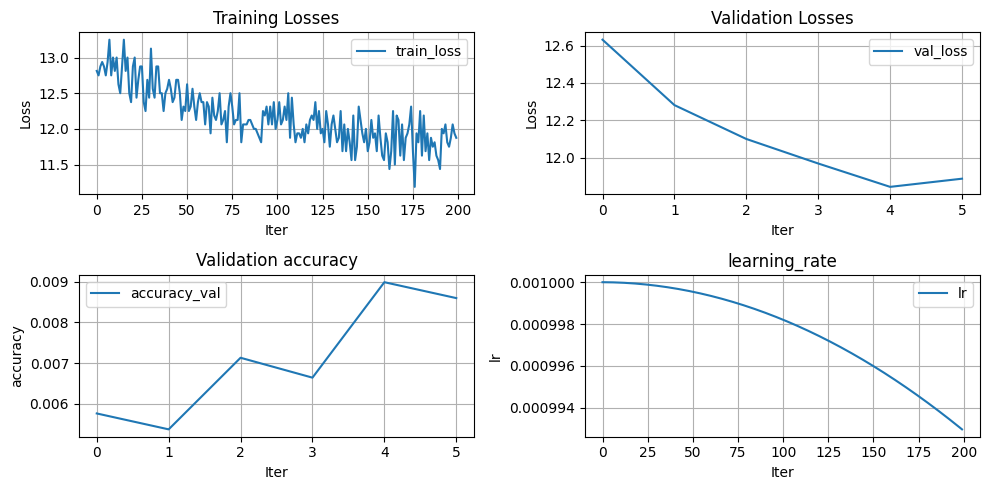

200


In [ ]:
# from torch.optim.lr_scheduler import LinearLR  # Corrected import
import numpy as np

losses = learning_loop(
    p_tuning_model,
    optimizer,
    train_dataloader,
    val_dataloader,
    nn.CrossEntropyLoss(),
    scheduler=scheduler,
    min_lr=None,
    epochs=num_epochs,
    val_every=30,
    draw_every=40,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
)



In [ ]:
print(losses['train'])

In [ ]:
print(losses['val'])

In [ ]:
print(losses['accuracy_val'])

In [ ]:
print(losses['lr'])